In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"


import findspark
findspark.init()
findspark.find()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [976 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Ge

'/usr/local/lib/python3.10/dist-packages/pyspark'

In [2]:
import nltk
from nltk.stem import PorterStemmer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

In [3]:
from google.colab import drive
import pyspark
from pyspark.sql import DataFrame, SparkSession
from typing import List
from pyspark.sql.functions import lower, col
from pyspark.sql.functions import regexp_replace
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.ml.feature import StopWordsRemover,Tokenizer,CountVectorizer, IDF
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
spark= SparkSession \
       .builder \
       .appName("BootCampEspol") \
       .getOrCreate()

spark

# Sentiment Analisis

In [5]:
df_post = spark.read.csv("/content/drive/MyDrive/Bootcamp/posts.csv", header=True,sep="/",multiLine=True,quote="")
df_comment = spark.read.csv("/content/drive/MyDrive/Bootcamp/comments.csv", header=True,sep="/",multiLine=True,quote="")

In [6]:
df_comment.show(3)

+--------------------+--------------------+-------------+--------------+
|                body|           sentiment|      POST_ID|subreddit.name|
+--------------------+--------------------+-------------+--------------+
|"I’m also a pries...|or considering re...|      -0.6705|        pr0dsu|
|"I'm guessing cov...|             -0.7729|       pr0dsu|          news|
|"Among law enforc...|                NULL|www.fox19.com|          2021|
+--------------------+--------------------+-------------+--------------+
only showing top 3 rows



In [7]:
df_post.show(3)

+--------------+-------+--------------------+--------------------+
|subreddit_name|post_id|               title|count(comment_score)|
+--------------+-------+--------------------+--------------------+
|     askreddit| psin9a|What are some of ...|                4156|
|     askreddit| mvicaw|Doctors of Reddit...|                3191|
|     askreddit| i1aa0m|If Covid never ha...|                2974|
+--------------+-------+--------------------+--------------------+
only showing top 3 rows



In [8]:
df_comment = df_comment.withColumnRenamed('subreddit.name', 'subreddit_name')

In [9]:
df_comment = df_comment.filter(col("subreddit_name").isin('askreddit', 'politics', 'coronavirus', 'conspiracy', 'news'))

In [10]:
df_comment = df_comment.filter(col("sentiment").isNotNull())

In [11]:
df_comment = df_comment.withColumn("sentiment", col("sentiment").cast("float"))

In [12]:
### Preproceso de los comentarios ###
df_comment = df_comment.withColumn("body", lower(col("body")))
df_post = df_post.withColumn("title",lower(col("title")))
### Retiramos los links, menciones, emojis de las columnas ###
# Expresión regular para detectar URLs
url_pattern = r'http\S+|www\S+'
### Expresion regular para las menciones
mention_pattern = r'@\w+'
### Expresion para los emojis
emoji_pattern = r'[^\w\s,]+'
### Remove part ###
df_comment = df_comment.withColumn("text_cleaned", regexp_replace("body", url_pattern, ""))
df_comment = df_comment.withColumn("text_cleaned", regexp_replace("text_cleaned", mention_pattern, ""))
df_comment = df_comment.withColumn("text_cleaned", regexp_replace("text_cleaned",emoji_pattern,""))
df_post = df_post.withColumn("text_cleaned", regexp_replace("title", url_pattern, ""))
df_post = df_post.withColumn("text_cleaned", regexp_replace("text_cleaned", mention_pattern, ""))
df_post = df_post.withColumn("text_cleaned", regexp_replace("text_cleaned",emoji_pattern,""))

In [13]:
### Proceso de analitica del texto ###
# Tokenización
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words")
# Eliminar stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# Aplicar HashingTF para convertir las palabras en características
count_Vector = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
# Aplicar TF-IDF
idf = IDF(inputCol="raw_features", outputCol="features")
#Modelo de regresion
lr = LinearRegression(featuresCol="features", labelCol="sentiment")

In [14]:
pipeline = Pipeline(stages=[tokenizer, remover, count_Vector, idf,lr])

In [15]:
train_data, test_data = df_comment.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)

In [16]:
predictions = model.transform(test_data)

# Evaluar el modelo
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="sentiment", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# También puedes calcular el R2
evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="sentiment", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R2: {r2}")


Root Mean Squared Error (RMSE): 0.9315705663368201
R2: -1.3578209162305828


In [17]:
predictions = model.transform(df_post)

In [18]:
predictions.select("title","prediction").show()

+--------------------+--------------------+
|               title|          prediction|
+--------------------+--------------------+
|what are some of ...| 0.10781367865930955|
|doctors of reddit...|-0.37773655074685064|
|if covid never ha...| 0.03053345402502805|
|after almost 1 ye...|-0.00298087407222...|
|how do you cope w...| 0.23849435016117707|
|‘i should have go...|  -0.252663397127306|
|[serious] when di...|-0.09461586018102852|
|it's more than li...|0.046698037184058294|
|people who had co...| -0.2832612961084936|
|discussion thread...|-0.46237948395666195|
|(serious) people ...|0.034849973357431174|
|houston hospital ...| -0.5618636771422874|
|discussion thread...|  0.8043720225225265|
|4 teachers died o...|  -1.351171699209813|
|who urges fully v...| -0.4430686164039206|
|what positive imp...|  0.3656935450500418|
|stephen miller re...|-0.41327981634983313|
|herd immunity fro...|-0.40854601145611025|
|discussion thread...|-0.32966713781182266|
|[serious] how wou...| -0.305923

# Comunidades

In [19]:
import nltk
from nltk.stem import PorterStemmer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

In [20]:
from google.colab import drive
import pyspark
from pyspark.sql import DataFrame, SparkSession
from typing import List
from pyspark.sql.functions import lower, col
from pyspark.sql.functions import regexp_replace
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.ml.feature import StopWordsRemover,Tokenizer,CountVectorizer, IDF
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

In [21]:
df = spark.read.csv("/content/drive/MyDrive/Bootcamp/mejor_post.csv", header=True,sep="/",multiLine=True,quote="")

In [22]:
df = df.na.drop(subset=["body"])

In [23]:
### Hacemos que todo el texto este en minusculas ###
df = df.withColumn("body", lower(col("body")))

In [24]:
### Retiramos los links, menciones, emojis de las columnas ###
# Expresión regular para detectar URLs
url_pattern = r'http\S+|www\S+'
### Expresion regular para las menciones
mention_pattern = r'@\w+'
### Expresion para los emojis
emoji_pattern = r'[^\w\s,]+'
### Remove part ###
df = df.withColumn("text_cleaned", regexp_replace("body", url_pattern, ""))
df = df.withColumn("text_cleaned", regexp_replace("text_cleaned", mention_pattern, ""))
df = df.withColumn("text_cleaned", regexp_replace("text_cleaned",emoji_pattern,""))

In [25]:
### Primero se hace el Tokenizer a la parte del texto ###
tokenizer = Tokenizer(inputCol="text_cleaned",outputCol="token_text")
df_1 = tokenizer.transform(df)
df_1.show()

+-------+--------------------+--------------------+--------------------+
|     id|                body|        text_cleaned|          token_text|
+-------+--------------------+--------------------+--------------------+
|hht1vil|"i'm so sorry thi...|im so sorry this ...|[im, so, sorry, t...|
|hhswtub|"your reply to me...|your reply to me ...|[your, reply, to,...|
|hhkv59l|not knowing at wh...|not knowing at wh...|[not, knowing, at...|
|hhitdz1|"well...\nsome pe...|well\nsome people...|[well, some, peop...|
|hhi7y4r|perhaps there wil...|perhaps there wil...|[perhaps, there, ...|
|hhhburi|ironically, news ...|ironically, news ...|[ironically,, new...|
|hhgbdv6|anxiety of workin...|anxiety of workin...|[anxiety, of, wor...|
|hhao0ob|i had fibroid  an...|i had fibroid  an...|[i, had, fibroid,...|
|hh9ldgk|"oh look the disi...|oh look the disin...|[oh, look, the, d...|
|hh9016v|"&gt; younger peo...|gt younger people...|[gt, younger, peo...|
|hh44f2u|she has gotten be...|she has gotten be...|

In [26]:
### Remover los stopwords del texto ###
remover = StopWordsRemover(inputCol="token_text",outputCol="token_stop")
df_1 = remover.transform(df_1)
df_1.show()

+-------+--------------------+--------------------+--------------------+--------------------+
|     id|                body|        text_cleaned|          token_text|          token_stop|
+-------+--------------------+--------------------+--------------------+--------------------+
|hht1vil|"i'm so sorry thi...|im so sorry this ...|[im, so, sorry, t...|[im, sorry, reply...|
|hhswtub|"your reply to me...|your reply to me ...|[your, reply, to,...|[reply, got, lost...|
|hhkv59l|not knowing at wh...|not knowing at wh...|[not, knowing, at...|[knowing, point, ...|
|hhitdz1|"well...\nsome pe...|well\nsome people...|[well, some, peop...|[well, people, gf...|
|hhi7y4r|perhaps there wil...|perhaps there wil...|[perhaps, there, ...|[perhaps, grammat...|
|hhhburi|ironically, news ...|ironically, news ...|[ironically,, new...|[ironically,, new...|
|hhgbdv6|anxiety of workin...|anxiety of workin...|[anxiety, of, wor...|[anxiety, working...|
|hhao0ob|i had fibroid  an...|i had fibroid  an...|[i, had, 

In [27]:
### Hacer un stemming del texto ###
# Descargar los recursos necesarios para nltk
nltk.download('punkt')

# Crear una instancia del stemmer
stemmer = PorterStemmer()

# Función para aplicar el stemming a cada palabra en la lista de tokens
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

# Convertir la función en un UDF de PySpark
stem_tokens_udf = udf(stem_tokens, ArrayType(StringType()))

# Aplicar la función de stemming a la columna 'words_filtered'
df_1 = df_1.withColumn("text_stemmed", stem_tokens_udf(df_1["token_stop"]))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [28]:
### Contar cuantas veces se repite una palabra en cada documento ###
count_vec = CountVectorizer(inputCol="text_stemmed",outputCol="count_vec")
df_1 = count_vec.fit(df_1).transform(df_1)
df_1.show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     id|                body|        text_cleaned|          token_text|          token_stop|        text_stemmed|           count_vec|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|hht1vil|"i'm so sorry thi...|im so sorry this ...|[im, so, sorry, t...|[im, sorry, reply...|[im, sorri, repli...|(12102,[0,1,2,4,8...|
|hhswtub|"your reply to me...|your reply to me ...|[your, reply, to,...|[reply, got, lost...|[repli, got, lost...|(12102,[0,2,3,4,5...|
|hhkv59l|not knowing at wh...|not knowing at wh...|[not, knowing, at...|[knowing, point, ...|[know, point, cov...|(12102,[1,2,15,18...|
|hhitdz1|"well...\nsome pe...|well\nsome people...|[well, some, peop...|[well, people, gf...|[well, peopl, gf,...|(12102,[0,1,2,5,1...|
|hhi7y4r|perhaps there wil...|perhaps there wil.

In [29]:
### TF-IDF ###
idf = IDF(inputCol="count_vec",outputCol="tf_idf")
df_1 = idf.fit(df_1).transform(df_1)
df_1.show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     id|                body|        text_cleaned|          token_text|          token_stop|        text_stemmed|           count_vec|              tf_idf|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|hht1vil|"i'm so sorry thi...|im so sorry this ...|[im, so, sorry, t...|[im, sorry, reply...|[im, sorri, repli...|(12102,[0,1,2,4,8...|(12102,[0,1,2,4,8...|
|hhswtub|"your reply to me...|your reply to me ...|[your, reply, to,...|[reply, got, lost...|[repli, got, lost...|(12102,[0,2,3,4,5...|(12102,[0,2,3,4,5...|
|hhkv59l|not knowing at wh...|not knowing at wh...|[not, knowing, at...|[knowing, point, ...|[know, point, cov...|(12102,[1,2,15,18...|(12102,[1,2,15,18...|
|hhitdz1|"well...\nsome pe...|well\nsome people...|[well, 

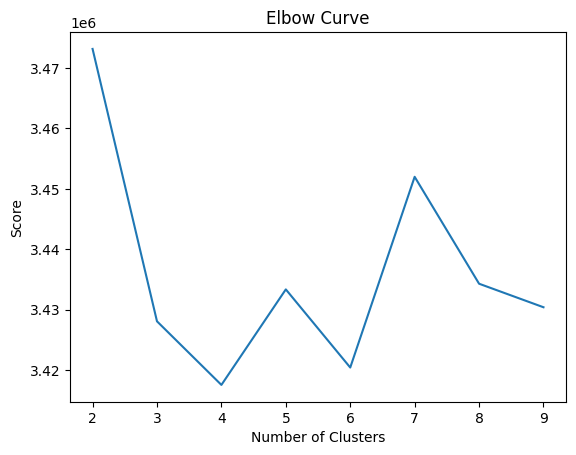

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('tf_idf')
    model = kmeans.fit(df_1)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()


In [31]:
### Kmeans con numero de K ya fijado ###
kmeans = KMeans(k=3, seed=1, featuresCol="tf_idf")
model = kmeans.fit(df_1)
predictions = model.transform(df_1)
predictions.select("id", "body", "prediction").show(truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
predictions.filter(predictions['prediction']==2).show(truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
predictions.filter(predictions['prediction']==1).show(truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
predictions.filter(predictions['prediction']==0).show(truncate=False)

+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [35]:
from wordcloud import WordCloud
from pyspark.sql.functions import collect_list

In [36]:
Grupo_2=predictions.filter(predictions['prediction']==2)

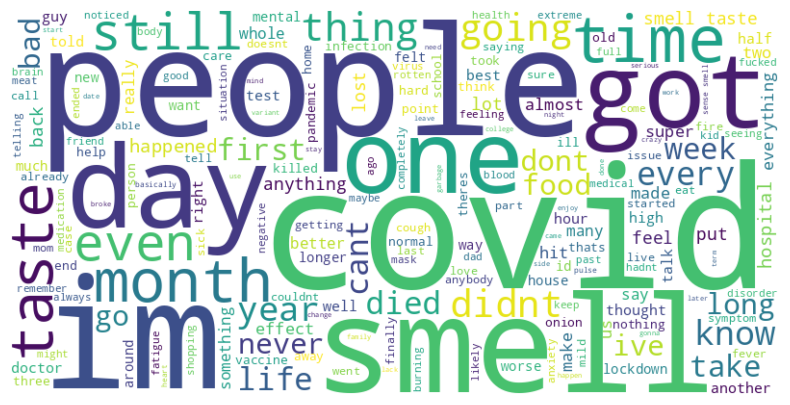

In [37]:
text_data = Grupo_2.select(collect_list("token_stop")).collect()[0][0]
if isinstance(text_data[0], list):
    # Aplanamos la lista de listas a una sola lista de palabras
    text_data = [word for sublist in text_data for word in sublist]
text = " ".join(text_data)  # Unir todos los comentarios en un solo texto
# Crear el WordCloud a partir de los comentarios
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

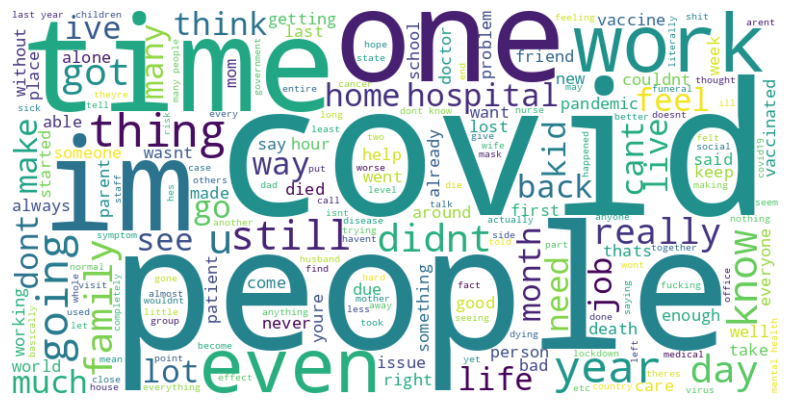

In [38]:
Grupo_1=predictions.filter(predictions['prediction']==1)
text_data = Grupo_1.select(collect_list("token_stop")).collect()[0][0]
if isinstance(text_data[0], list):
    # Aplanamos la lista de listas a una sola lista de palabras
    text_data = [word for sublist in text_data for word in sublist]
text = " ".join(text_data)  # Unir todos los comentarios en un solo texto
# Crear el WordCloud a partir de los comentarios
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

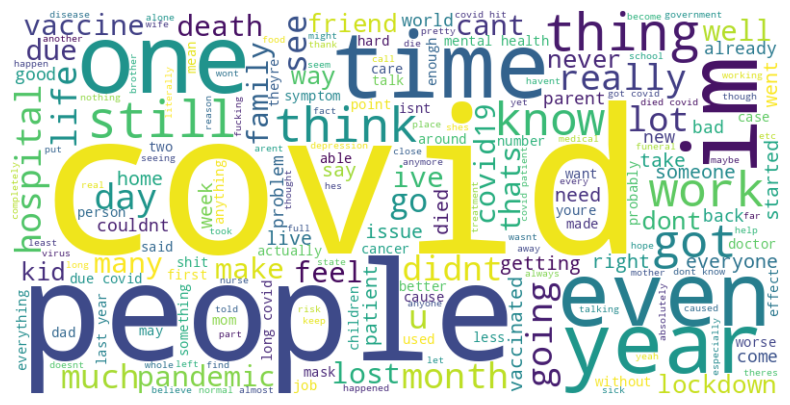

In [39]:
Grupo_0=predictions.filter(predictions['prediction']==0)
text_data = Grupo_0.select(collect_list("token_stop")).collect()[0][0]
if isinstance(text_data[0], list):
    # Aplanamos la lista de listas a una sola lista de palabras
    text_data = [word for sublist in text_data for word in sublist]
text = " ".join(text_data)  # Unir todos los comentarios en un solo texto
# Crear el WordCloud a partir de los comentarios
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()